
# Supernovae distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus:

$$\mu = m - M = 5\text{log}_{10}\left(\frac{d_L}{pc}\right) - 5$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored.

These are some (synthetic but realistic; see textbook) supernova data:

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

np.random.seed(123)

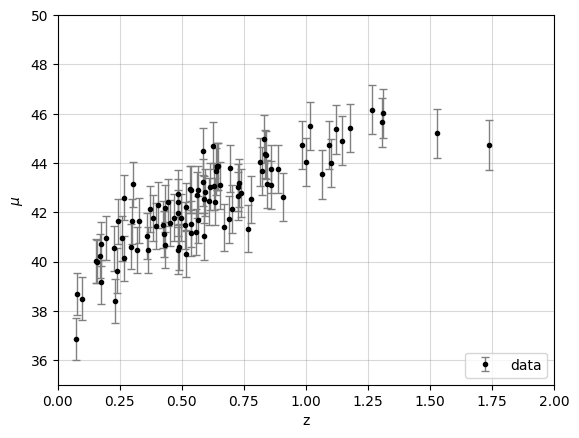

In [41]:
N = 100     # Number of samples to generate
z_sample, mu_sample, dmu = generate_mu_z(N, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()


### Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

## Linear regression

[39.56505555] [[4.64711848]]


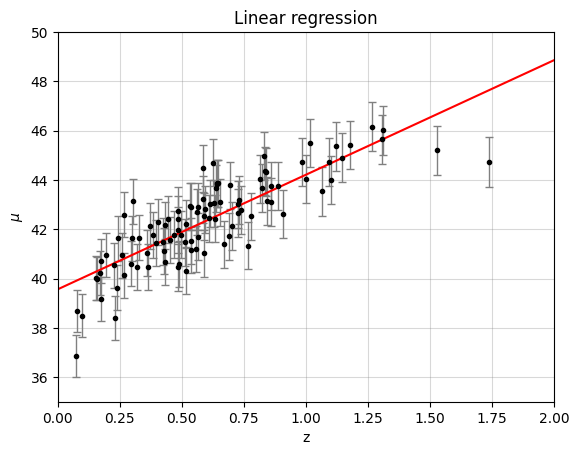

In [42]:
z = z_sample[:, np.newaxis]     # z_sample for plotting, z for fitting
mu = mu_sample[:, np.newaxis]

lin_reg = LinearRegression()
lin_reg.fit(z, mu, sample_weight=1)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

xgrid = np.linspace(0, 2.0, 10)
Y_pred = theta0 + theta1 * xgrid

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1)
plt.plot(xgrid, Y_pred[0], c = 'red')
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.grid(alpha=0.3, c='gray')
plt.title('Linear regression')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Polynomial regression

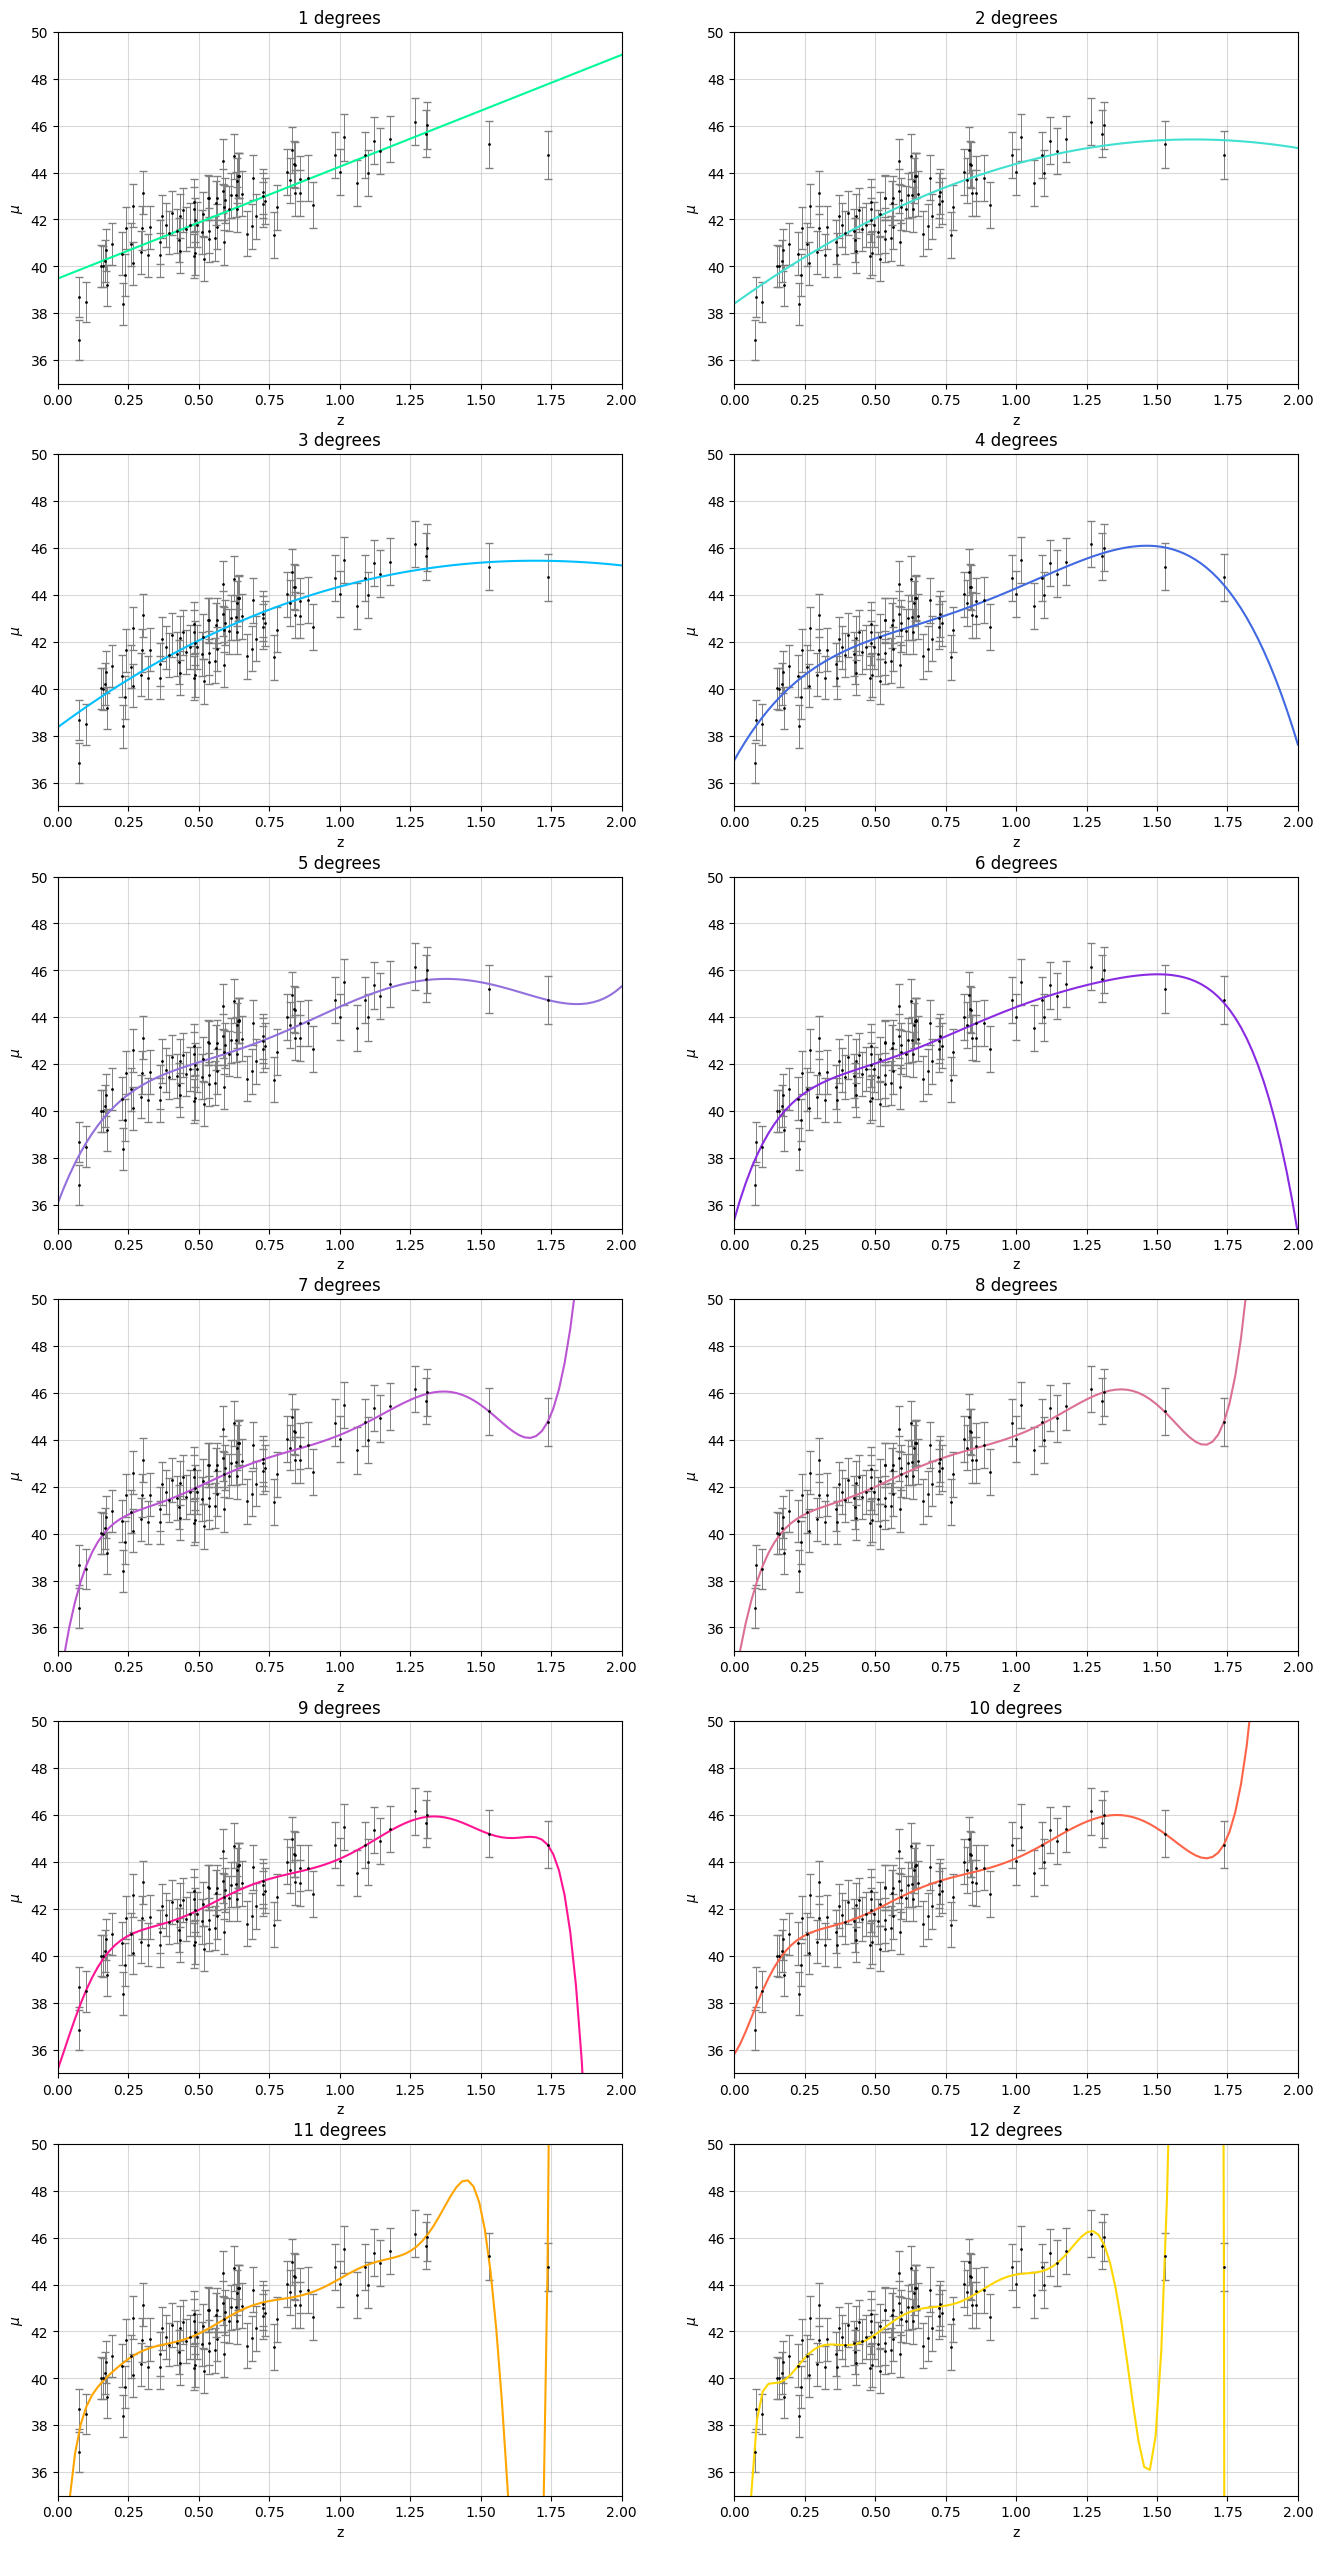

In [43]:
X_points = np.linspace(0, 2.0, 100)
xgrid = X_points[:, np.newaxis]

fig = plt.figure(figsize=(16, 32))

colors = ['mediumspringgreen', 'turquoise', 'deepskyblue', 'royalblue', 'mediumpurple', 'blueviolet', 'mediumorchid', 'palevioletred', 'deeppink', 'tomato', 'orange', 'gold']
degrees = np.arange(1, 13)

for i, degree in enumerate(degrees):
    ax = fig.add_subplot(6,2,1+i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)
    
    model = PolynomialRegression(degree)
    model.fit(z, mu_sample, dmu)     # z.shape = (100, 1), mu.shape = (100, 1), PolynomialRegression wants the y to be (100, ) ---> using mu_sample
    y_poly = model.predict(xgrid)
    
    plt.plot(xgrid, y_poly, lw = 1.5, color = colors[i])
    plt.xlabel('z')
    plt.ylabel('$\\mu$')
    plt.grid(alpha=0.3, c='gray')
    plt.title('%i degrees' % degree)
    plt.xlim(0,2)
    plt.ylim(35,50)
    
plt.show()

Judging by these plots, the linear fit seems to be underfitting the data, while over 7 degrees the polynomials clearly overfit the data. Out of all of them, the $2-$ and $3-$degrees polynomials seem to be the best fits for the data. The $4-$degrees one captures well the last points, but they can be outliers: if that's the case, any other point after them will be poorly predicted.

Let's see what is the best fit according to cross validation:

### Cross validation

Since the computational cost still allows it, I'm gonna use a leave-one-out cross-validation:

Degree: 1 - Train: 0.9865 - Test: 0.7813
Degree: 2 - Train: 0.9038 - Test: 0.7471
Degree: 3 - Train: 0.9039 - Test: 0.7708
Degree: 4 - Train: 0.8712 - Test: 0.7563
Degree: 5 - Train: 0.8648 - Test: 0.7270
Degree: 6 - Train: 0.8625 - Test: 0.9321
Degree: 7 - Train: 0.8493 - Test: 0.7370
Degree: 8 - Train: 0.8491 - Test: 1.0853
Degree: 9 - Train: 0.8482 - Test: 1.1883
Degree: 10 - Train: 0.8481 - Test: 2.4019
Degree: 11 - Train: 0.8456 - Test: 52.1954
Degree: 12 - Train: 0.8296 - Test: 12.1110
Degree: 13 - Train: 0.8281 - Test: 425.4799
Degree: 14 - Train: 0.8143 - Test: 309.7248
Degree: 15 - Train: 0.8139 - Test: 1317.3468
Degree: 16 - Train: 0.8121 - Test: 7042.4237

The best model is the one with 5 degrees



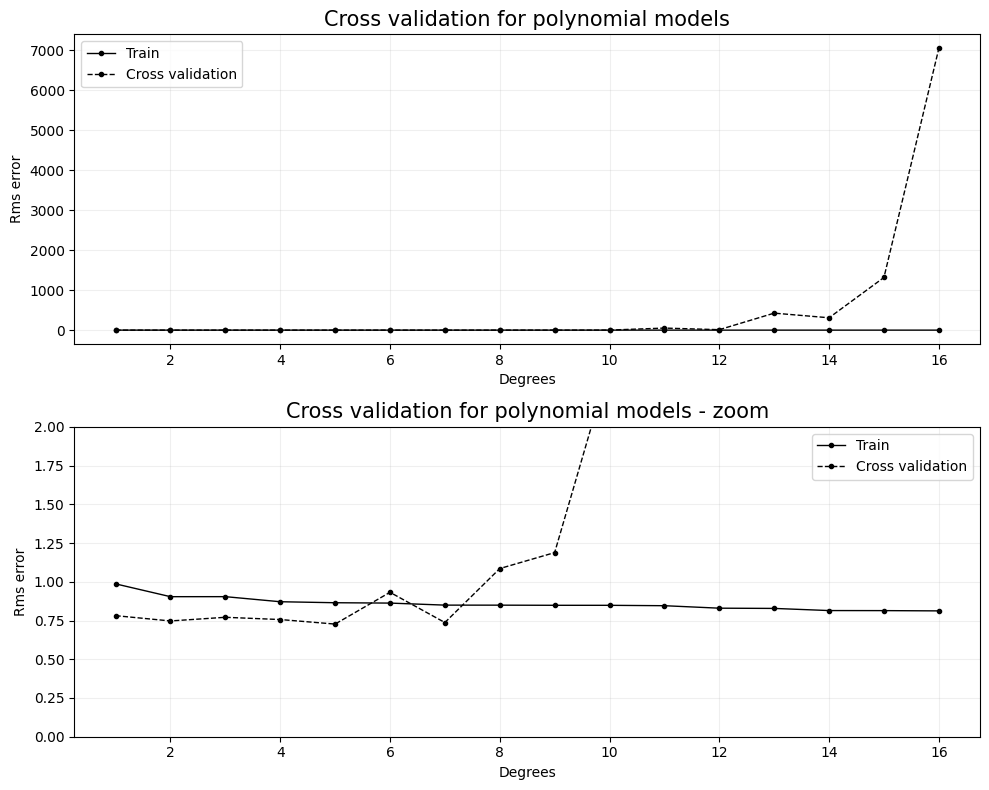

In [56]:
n_splits = 100
degrees = np.arange(1, 17)

rms_train_tot = np.empty(len(degrees))
rms_test_tot = np.empty(len(degrees))

for j, degree in enumerate(degrees):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)     # Splitting the data in train and test
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
        z_train, z_test = z[train_index], z[test_index]
        mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
        dmu_train, dmu_test = dmu[train_index], dmu[test_index]
    
        model = PolynomialRegression(degree)
        model.fit(z_train, mu_train, dmu_train)
        
        # Remember, I want to evaluate the rms both on the training data and the test data!
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))
    
    print('Degree: %i - Train: %.4f - Test: %.4f' % (degree, np.mean(rms_train), np.mean(rms_test)))
    rms_train_tot[j] = np.mean(rms_train)
    rms_test_tot[j] = np.mean(rms_test)

print('\nThe best model is the one with %i degrees\n' % degrees[np.argmin(rms_test_tot)])

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(degrees, rms_train_tot, lw = 1, color = 'black', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[0].plot(degrees, rms_test_tot, lw = 1, color = 'black', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[0].set_xlabel('Degrees')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Cross validation for polynomial models', fontsize = 15)
ax[0].grid(alpha = 0.2)
ax[0].legend()

ax[1].plot(degrees, rms_train_tot, lw = 1, color = 'black', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[1].plot(degrees, rms_test_tot, lw = 1, color = 'black', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[1].set_xlabel('Degrees')
ax[1].set_ylabel('Rms error')
ax[1].set_ylim(0, 2)
ax[1].set_title('Cross validation for polynomial models - zoom', fontsize = 15)
ax[1].grid(alpha = 0.2)
ax[1].legend()

plt.tight_layout(w_pad=2.5)
plt.show()

We can now plot the learning curve:

In [57]:
dataset_size = np.array(np.arange(5, 101, 5))
np.random.seed(123)

rms_train_lc = np.empty(len(dataset_size))
rms_test_lc= np.empty(len(dataset_size)) 

for index, ds in enumerate(dataset_size):
    
    # Choosing randomly the n = ds indexes for the data:
    data_indexes = np.random.choice(np.arange(0, 100), size=ds, replace=False)
    z_lc = z[data_indexes]
    mu_sample_lc = mu_sample[data_indexes]
    dmu_lc = dmu[data_indexes]
    
    n_splits = ds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=None) 
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z_lc), np.arange(n_splits)):
        
        z_train, z_test = z_lc[train_index], z_lc[test_index]
        mu_train, mu_test = mu_sample_lc[train_index], mu_sample_lc[test_index]
        dmu_train, dmu_test = dmu_lc[train_index], dmu_lc[test_index]
        
        model = PolynomialRegression(5)     # Best polynomial model
        model.fit(z_train, mu_train, dmu_train)
    
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))

    rms_train_lc[index] = np.mean(rms_train)
    rms_test_lc[index] = np.mean(rms_test)

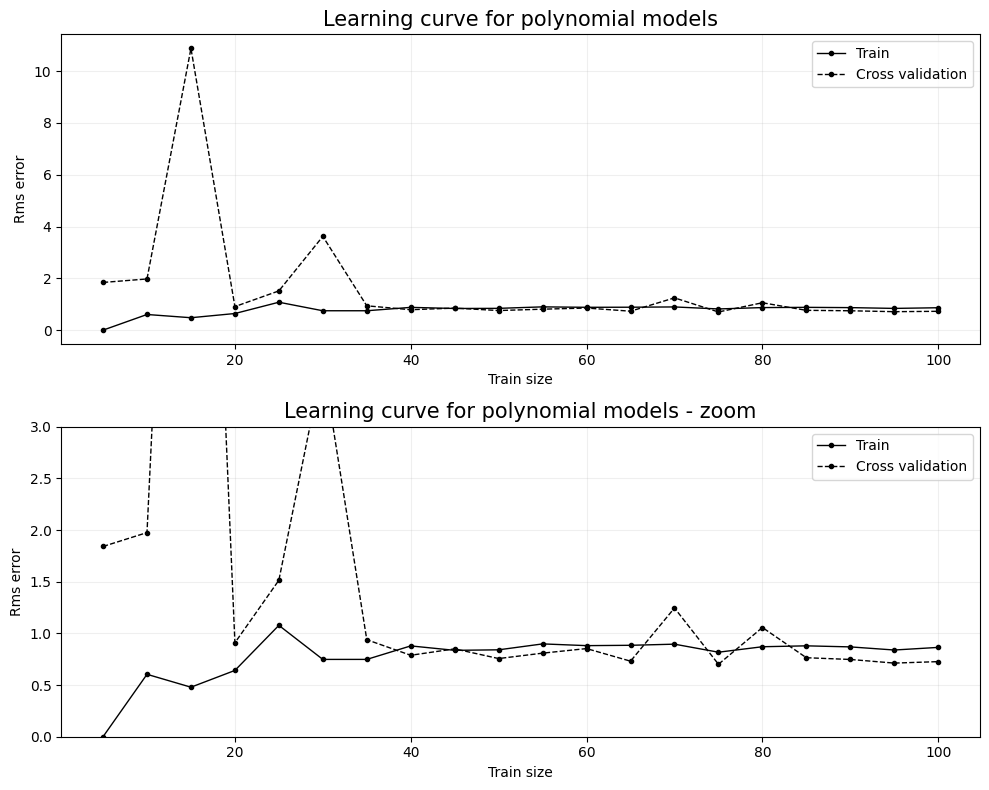

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(dataset_size, rms_train_lc, lw = 1, color = 'black', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[0].plot(dataset_size, rms_test_lc, lw = 1, color = 'black', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[0].set_xlabel('Train size')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Learning curve for polynomial models', fontsize = 15)
ax[0].grid(alpha = 0.2)
ax[0].legend()

ax[1].plot(dataset_size, rms_train_lc, lw = 1, color = 'black', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[1].plot(dataset_size, rms_test_lc, lw = 1, color = 'black', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[1].set_xlabel('Train size')
ax[1].set_ylabel('Rms error')
ax[1].set_ylim(0, 3)
ax[1].set_title('Learning curve for polynomial models - zoom', fontsize = 15)
ax[1].grid(alpha = 0.2)
ax[1].legend()

plt.tight_layout(w_pad=2.5)
plt.show()

So, it looks that a dataset of $\sim40$ points is sufficient, and thus we don't need more data to improve the model fitting.

## Basis function regression

Let's try now with basis function regression, using Gaussian functions as a basis. We can first try with a fixed sigma value, cross-validating to find the best number of gaussians:

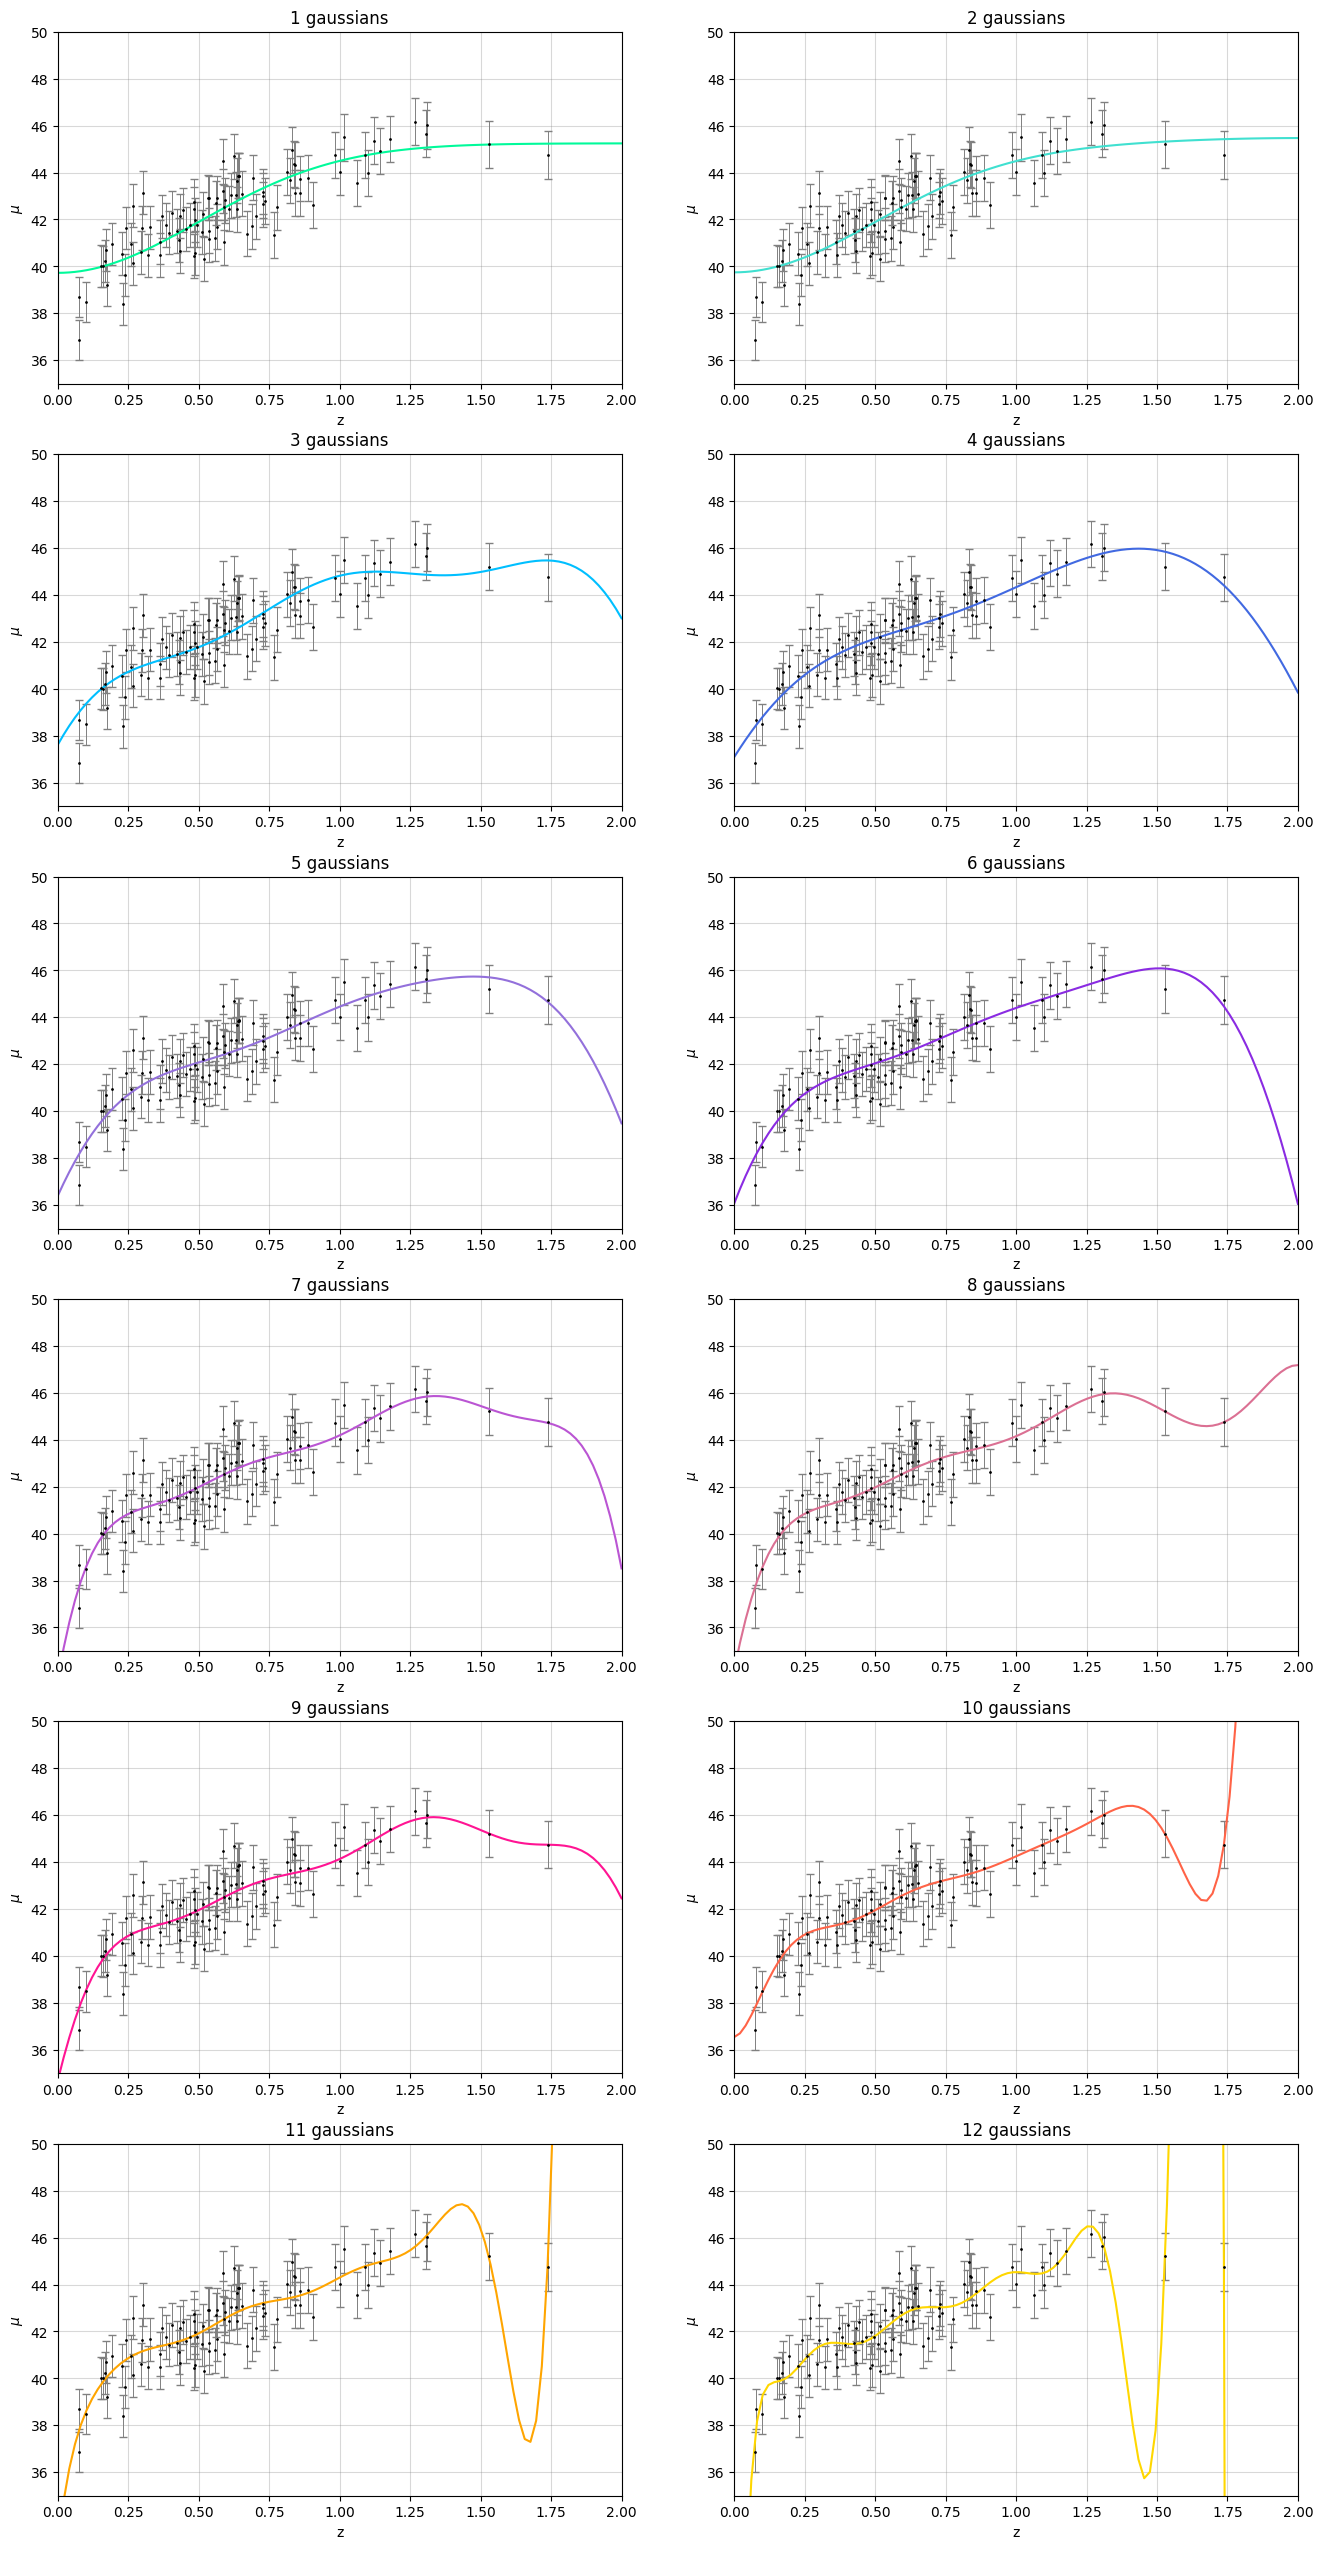

In [85]:
X_points = np.linspace(0, 2.0, 100)
xgrid = X_points[:, np.newaxis]

fig = plt.figure(figsize=(16, 32))

n_gaussians = np.arange(1, 13)
sigma = 0.5

for i, n in enumerate(n_gaussians):
    ax = fig.add_subplot(6,2,1+i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)

    centers_points = np.linspace(0, 2.0, n)     # I want n gaussians -> centering them in a linspace of n points
    centers = centers_points[:, np.newaxis]
    model = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma)
    model.fit(z, mu_sample, dmu)
    y_gauss = model.predict(xgrid)
    
    plt.plot(xgrid, y_gauss, lw = 1.5, color = colors[i])
    plt.xlabel('z')
    plt.ylabel('$\\mu$')
    plt.grid(alpha=0.3, c='gray')
    plt.title('%i gaussians' % n)
    plt.xlim(0,2)
    plt.ylim(35,50)
    
plt.show()

In this case, too, we'll perform a leave-one-out cross-validation:

Number of gaussians: 1 - Train: 0.9481 - test: 0.7611
Number of gaussians: 2 - Train: 0.9474 - test: 0.7712
Number of gaussians: 3 - Train: 0.9272 - test: 0.7804
Number of gaussians: 4 - Train: 0.8715 - test: 0.7407
Number of gaussians: 5 - Train: 0.8677 - test: 0.7398
Number of gaussians: 6 - Train: 0.8660 - test: 0.8484
Number of gaussians: 7 - Train: 0.8488 - test: 0.7440
Number of gaussians: 8 - Train: 0.8483 - test: 0.7223
Number of gaussians: 9 - Train: 0.8481 - test: 1.2244
Number of gaussians: 10 - Train: 0.8466 - test: 1.7035
Number of gaussians: 11 - Train: 0.8458 - test: 21.3649
Number of gaussians: 12 - Train: 0.8242 - test: 20.8026

The best model is the one with 8 gaussians



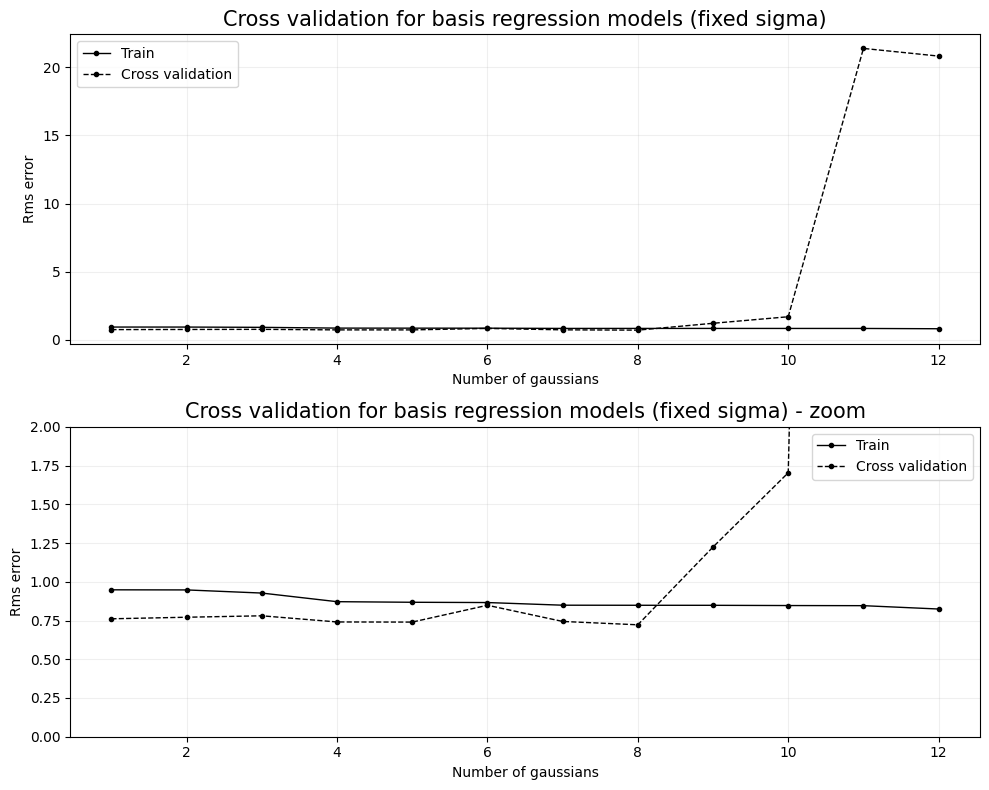

In [86]:
n_splits = 100

rms_train_tot = np.empty(len(n_gaussians))
rms_test_tot = np.empty(len(n_gaussians))

for j, n in enumerate(n_gaussians):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)     # Splitting the data in train and test
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
        z_train, z_test = z[train_index], z[test_index]
        mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
        dmu_train, dmu_test = dmu[train_index], dmu[test_index]

        centers_points = np.linspace(0, 2.0, n)
        centers = centers_points[:, np.newaxis]
        model = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma)
        model.fit(z_train, mu_train, dmu_train)
        
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))
    
    print('Number of gaussians: %i - Train: %.4f - test: %.4f' % (n, np.mean(rms_train), np.mean(rms_test)))
    rms_train_tot[j] = np.mean(rms_train)
    rms_test_tot[j] = np.mean(rms_test)

print('\nThe best model is the one with %i gaussians\n' % n_gaussians[np.argmin(rms_test_tot)])

fig, ax = plt.subplots(2, 1, figsize = (10, 8))

ax[0].plot(n_gaussians, rms_train_tot, lw = 1, color = 'black', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[0].plot(n_gaussians, rms_test_tot, lw = 1, color = 'black', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[0].set_xlabel('Number of gaussians')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Cross validation for basis regression models (fixed sigma)', fontsize = 15)
ax[0].grid(alpha = 0.2)
ax[0].legend()

ax[1].plot(n_gaussians, rms_train_tot, lw = 1, color = 'black', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[1].plot(n_gaussians, rms_test_tot, lw = 1, color = 'black', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[1].set_xlabel('Number of gaussians')
ax[1].set_ylabel('Rms error')
ax[1].set_ylim(0, 2)
ax[1].set_title('Cross validation for basis regression models (fixed sigma) - zoom', fontsize = 15)
ax[1].grid(alpha = 0.2)
ax[1].legend()

plt.tight_layout(w_pad=2.5)
plt.show()

If we instead leave sigma as a free parameter, we can cross-validate both on the centers of the gaussians and their standard deviation:

In [91]:
n_splits = 100

sigma_try = np.linspace(0.1, 1, 10)

# Matrix: 
# sigma1, n1     sigma1, n2     ...
# sigma2, n1     sigma2, n2     ...
#    ...            ...         ...

rms_test_matrix = np.empty((len(sigma_try), len(n_gaussians)))

for k, sigma in enumerate(sigma_try):
    for j, n in enumerate(n_gaussians):

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=None)
    
        rms_test = np.empty(n_splits)     # I won't keep track of the rms_train this time, there's no plot

        for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
            z_train, z_test = z[train_index], z[test_index]
            mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
            dmu_train, dmu_test = dmu[train_index], dmu[test_index]
    
            centers_points = np.linspace(0, 2.0, n)
            centers = centers_points[:, np.newaxis]
            model = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma)
            model.fit(z_train, mu_train, dmu_train)

            rms_test[j] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))

        rms_test_matrix[k, j] = np.mean(rms_test)

print(rms_test_matrix)

[[21.39487948 20.82155828 21.40251617 20.8271606  21.41148652 20.82261057
  21.41027953 20.82532604 21.40827678 20.82431181 21.39689633 20.81659736]
 [21.38661879 20.79375502 21.3849751  20.79828862 21.38539464 20.7998405
  21.38120742 20.79832887 21.37432925 20.79416643 21.38439096 20.80167112]
 [21.37725143 20.79426744 21.36808115 20.77911168 21.35905205 20.77395849
  21.35834811 20.77501196 21.36190027 20.77541872 21.36153345 20.76773464]
 [21.36733781 20.77253952 21.37079763 20.77130248 21.36779318 20.77422826
  21.36787534 20.77190532 21.38365969 20.76695157 21.38448908 20.76315135]
 [21.3787508  20.75715112 21.38167388 20.76879009 21.38109964 20.77264097
  21.37931454 20.77237421 21.36667409 20.7761172  21.35806546 20.78606794]
 [21.36756067 20.79316677 21.36872447 20.78686356 21.375912   20.78568439
  21.37412059 20.78909461 21.3674395  20.79109029 21.36901882 20.79216986]
 [21.36486824 20.79262349 21.3649451  20.78540953 21.36856821 20.79990958
  21.37385461 20.79986169 21.3725

In [90]:
min_index_flat = np.argmin(rms_test_matrix)
    
min_index_2d = np.unravel_index(min_index_flat, rms_test_matrix.shape)

n_best = n_gaussians[min_index_2d[1]]
sigma_best = sigma_try[min_index_2d[0]]

print(min_index_2d)
print('Best number of gaussians: %i' % n_best)
print('Best sigma: %0.2f' % sigma_best)

(5, 11)
Best number of gaussians: 12
Best sigma: 0.60


We can confront this model with the fixed sigma one:

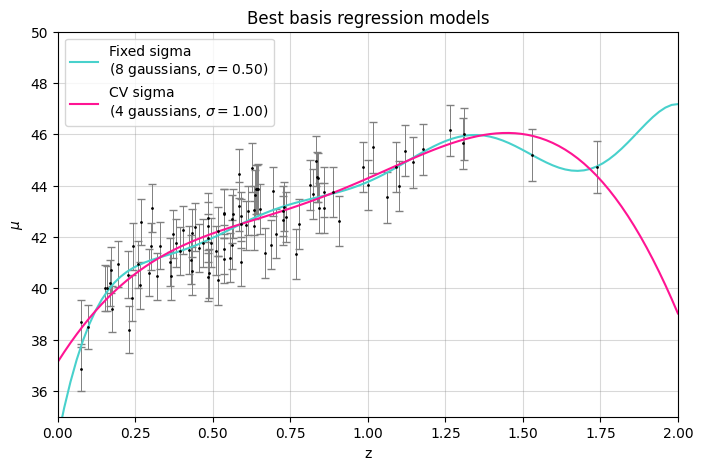

In [80]:
# Best model for fixed sigma: n = 8, sigma = 0.5
n_best_fix = 8
sigma_fix = 0.5

centers_points_fix = np.linspace(0, 2.0, n_best_fix)
centers_fix = centers_points_fix[:, np.newaxis]

model_fix = BasisFunctionRegression('gaussian', mu = centers_fix, sigma = sigma_fix)
model_fix.fit(z, mu_sample, dmu)
y_fix = model_fix.predict(xgrid)

# Best model for cross-validated sigma: n = 4, sigma = 1.00
centers_points_cv = np.linspace(0, 2.0, n_best)
centers_cv = centers_points_cv[:, np.newaxis]

model_cv = BasisFunctionRegression('gaussian', mu = centers_cv, sigma = sigma_best)
model_cv.fit(z, mu_sample, dmu)
y_cv = model_cv.predict(xgrid)
                                      
# Plotting
plt.figure(figsize=(8, 5))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)

plt.plot(xgrid, y_fix, lw = 1.5, color = 'mediumturquoise', label = 'Fixed sigma\n(%i gaussians, $\\sigma=$%0.2f)' % (n_best_fix, sigma_fix))
plt.plot(xgrid, y_cv, lw = 1.5, color = 'deeppink', label = 'CV sigma\n(%i gaussians, $\\sigma=$%0.2f)' % (n_best, sigma_best))
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.grid(alpha=0.3, c='gray')
plt.title('Best basis regression models')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc = 'upper left')
plt.show()

The two models are fairly similar in the first part of the plot, where there's many points guiding the fit. For $z\gtrsim1.25$, instead, the models behave differently: the 4-gaussians one follows the lower points, while the 8-gaussians one passes through them and then rises again. I'd say that the 8-gaussians one is a case of overfitting. 



TO DO:

- Cross-validation basis con sigma libero
- Kernel regression
- Cross-validation per la kernel regression
- Fai il grafico di quelli che sono risultati i modelli migliori
- Fai le learning curves